In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Deepsig was used to make these predictions
#https://academic.oup.com/bioinformatics/article/34/10/1690/4769493
sig_pep_df = pd.read_csv('../inputs/signal_peptide_genes.csv')
sig_pep_df.head()

,ProteinID,PredictedSignal,Reliability,CleavageSite
0,Igfbp5,SignalPeptide,1.00,19
1,Ramp1,SignalPeptide,0.98,26
2,Ccdc3,SignalPeptide,1.00,21
3,C1ql3,SignalPeptide,1.00,20
4,Mrc1,SignalPeptide,0.99,22


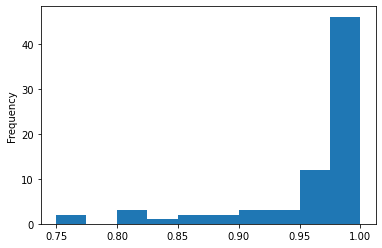

In [7]:
sig_pep_df['Reliability'].plot.hist()
plt.show()
plt.close()

In [8]:
sig_pep_df = sig_pep_df[sig_pep_df['Reliability'].ge(0.95)]
sig_pep_df.shape

(58, 4)

## Testing if median gene/ont peripheralness depends on presence of signal peptide

In [9]:
mop_df = pd.read_csv('../outputs/gene_ontology/MOp_peripheral_ReadZs_gene_ontology.csv')
mop_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,0.000082,0.000293
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,0.261199,0.367769
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,0.000003,0.000015
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,0.019019,0.040833
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,0.415606,0.527449


In [12]:
genes_with_sig_pep = set(sig_pep_df['ProteinID'])
mop_df['has_sig_pep'] = mop_df['gene'].isin(genes_with_sig_pep)
mop_df.head()

,sample_id,gene,ontology,num_cells,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,has_sig_pep
0,m1s1,Acta2,L2/3 IT,397,6.0,611.0,0.087413,26.992258,46.958252,3.938975,0.000082,0.000293,False
1,m1s1,Acta2,L5 ET,51,6.0,698.0,0.032479,2.767631,6.067670,1.123562,0.261199,0.367769,False
2,m1s1,Acta2,L5 IT,257,6.0,654.0,0.094270,25.067569,29.188310,4.639891,0.000003,0.000015,False
3,m1s1,Acta2,L6 CT,26,5.0,304.0,0.176217,4.241585,3.271222,2.345164,0.019019,0.040833,False
4,m1s1,Acta2,L6 IT,85,6.0,569.0,0.035714,2.599184,10.194193,0.814068,0.415606,0.527449,False


In [14]:
mop_df['has_sig_pep'].value_counts()

False    8597
True     2943
Name: has_sig_pep, dtype: int64

In [85]:
mop_df[mop_df['has_sig_pep']]['gene'].value_counts()

Ptprt       175
Igfbp5      165
Shisa9      143
Cdh13       136
Parm1       133
Spon1       128
Sema5a      122
Grin3a      119
Cxcl14      116
Prss12       98
Olfm3        96
Grm1         95
Npnt         80
Cdh12        80
Pcdh8        75
Flrt3        73
Ramp1        70
C1ql3        67
Rxfp1        67
Ntng2        65
Ccdc3        63
Nxph1        59
Tmtc2        53
Ctss         52
Elfn1        51
Cbln4        45
Gpc6         44
Pdgfra       39
Sema3e       37
Thbs2        37
Alk          37
Unc5b        34
Vtn          31
Moxd1        31
Serpinf1     29
Ccdc80       25
Bgn          25
Il1rapl2     22
Pdgfc        21
Mrc1         21
Rspo1        18
Rxfp2        16
Nxph4        16
Cd14         12
Tnfaip6      11
Hpse          8
Ror1          2
Chodl         1
Name: gene, dtype: int64

In [86]:
'Ptprt' in genes_with_sig_pep

True

In [79]:
import scipy as scp

ttest_data = {
    'ont':[],
    'sig_pep_more_central':[],
    'med_periph_with_signal':[],
    'med_periph_without_signal':[],
    'num_genes_with_signal_pep':[],
    'num_genes_without_signal_pep':[],
    'p':[],
    'statistic':[],
}
for ont,g in mop_df.groupby('ontology'):
    v1 = g.loc[g['has_sig_pep'],'med_score'].values
    v2 = g.loc[~g['has_sig_pep'],'med_score'].values
    s,p = scp.stats.ttest_ind(v1,v2)
    ttest_data['ont'].append(ont)
    ttest_data['sig_pep_more_central'].append(np.median(v1) < np.median(v2))
    ttest_data['med_periph_with_signal'].append(np.median(v1))
    ttest_data['med_periph_without_signal'].append(np.median(v2))
    ttest_data['num_genes_with_signal_pep'].append(len(v1))
    ttest_data['num_genes_without_signal_pep'].append(len(v2))
    ttest_data['p'].append(p)
    ttest_data['statistic'].append(s)
    
ttest_df = pd.DataFrame(ttest_data).sort_values('p')


#perform BH correction
from statsmodels.stats import multitest

_,adj_p,_,_ = multitest.multipletests(
    ttest_df['p'],
    alpha = 0.05,
    method = 'fdr_bh',
)
ttest_df['bh_p'] = adj_p
ttest_df['significant'] = adj_p <= .05
ttest_df

,ont,sig_pep_more_central,med_periph_with_signal,med_periph_without_signal,num_genes_with_signal_pep,num_genes_without_signal_pep,p,statistic,bh_p,significant
14,SMC,False,0.029630,-0.063407,133,348,2.627853e-10,6.456790,4.992921e-09,True
2,L2/3 IT,False,0.038182,0.019074,278,907,6.816600e-10,6.221599,6.475770e-09,True
12,Oligo,False,0.038391,0.006674,103,406,3.751191e-06,4.676263,2.375754e-05,True
17,VLMC,False,-0.006211,-0.053763,137,333,5.397122e-06,4.601973,2.563633e-05,True
1,Endo,False,0.088090,-0.037856,61,140,3.140609e-03,2.990121,1.193431e-02,True
0,Astro,False,0.065574,0.000000,89,331,4.402159e-03,2.863402,1.394017e-02,True
3,L5 ET,False,0.012503,-0.006708,235,663,8.158472e-03,2.651356,2.214442e-02,True
13,Pvalb,False,0.006966,-0.002950,193,591,2.367031e-02,2.266873,5.621699e-02,False
8,L6 IT Car3,False,0.028093,0.010363,133,336,2.884466e-02,2.192382,6.089428e-02,False
6,L6 CT,False,0.021004,0.010941,198,705,3.778079e-02,2.080293,7.178351e-02,False


In [90]:
mop_df.shape

(11540, 14)

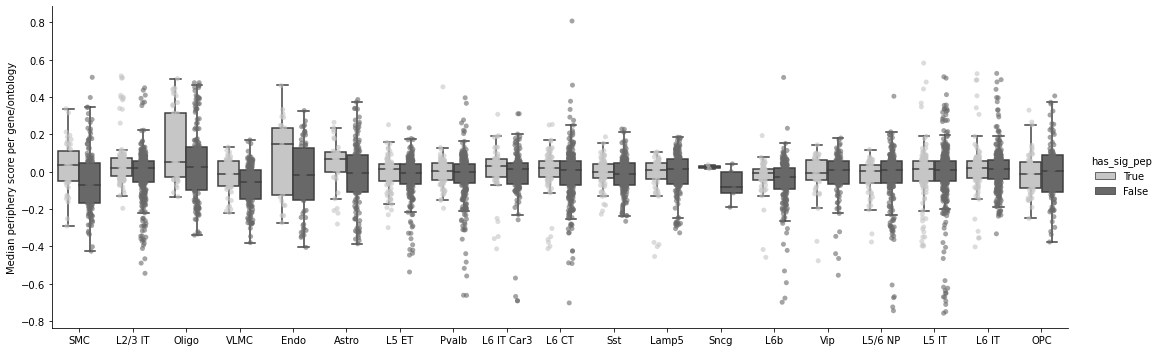

In [94]:
#Tried sorting by increasing score for visualization, but didn't help much
#mop_df['ont_med_score'] = mop_df.groupby('ontology')['med_score'].transform('median')

g = sns.catplot(
    kind = 'box',
    x = 'ontology',
    y = 'med_score',
    order = ttest_df['ont'],
    hue = 'has_sig_pep',
    hue_order = [True,False],
    palette = 'Greys',
    fliersize = 0,
    aspect = 3,
    data = mop_df.sample(5000), #too many spots making figure very large!
)
g.map_dataframe(
    sns.stripplot,
    x = 'ontology',
    y = 'med_score',
    order = ttest_df['ont'],
    hue = 'has_sig_pep',
    hue_order = [True,False],
    palette = 'Greys',
    alpha=0.6,
    dodge=True,
)
plt.xlabel('')
plt.ylabel('Median periphery score per gene/ontology')
plt.show()
g.savefig('signal_peptide_peripheralness.svg')
plt.close()

In [88]:
ttest_df

,ont,sig_pep_more_central,med_periph_with_signal,med_periph_without_signal,num_genes_with_signal_pep,num_genes_without_signal_pep,p,statistic,bh_p,significant
14,SMC,False,0.029630,-0.063407,133,348,2.627853e-10,6.456790,4.992921e-09,True
2,L2/3 IT,False,0.038182,0.019074,278,907,6.816600e-10,6.221599,6.475770e-09,True
12,Oligo,False,0.038391,0.006674,103,406,3.751191e-06,4.676263,2.375754e-05,True
17,VLMC,False,-0.006211,-0.053763,137,333,5.397122e-06,4.601973,2.563633e-05,True
1,Endo,False,0.088090,-0.037856,61,140,3.140609e-03,2.990121,1.193431e-02,True
0,Astro,False,0.065574,0.000000,89,331,4.402159e-03,2.863402,1.394017e-02,True
3,L5 ET,False,0.012503,-0.006708,235,663,8.158472e-03,2.651356,2.214442e-02,True
13,Pvalb,False,0.006966,-0.002950,193,591,2.367031e-02,2.266873,5.621699e-02,False
8,L6 IT Car3,False,0.028093,0.010363,133,336,2.884466e-02,2.192382,6.089428e-02,False
6,L6 CT,False,0.021004,0.010941,198,705,3.778079e-02,2.080293,7.178351e-02,False
